In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
import os
import glob
import numpy as np
import nibabel as nib
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from scipy.ndimage import label
from scipy.stats import mode

## Data preparation

In [3]:
class BrainMetastasesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.patients = os.listdir(root_dir)
        self.valid_patients = self._filter_valid_patients()

    def _filter_valid_patients(self):
        valid_patients = []
        for patient in self.patients:
            patient_folder = os.path.join(self.root_dir, patient)
            seg_path = glob.glob(os.path.join(patient_folder, '*seg.nii'))
            if seg_path:
                valid_patients.append(patient)
        return valid_patients

    def __len__(self):
        return len(self.valid_patients)

    def __getitem__(self, idx):
        patient_folder = os.path.join(self.root_dir, self.valid_patients[idx])

        # Paths
        t1n_path = glob.glob(os.path.join(patient_folder, '*t1n.nii'))
        t1c_path = glob.glob(os.path.join(patient_folder, '*t1c.nii'))
        t2w_path = glob.glob(os.path.join(patient_folder, '*t2w.nii'))
        t2f_path = glob.glob(os.path.join(patient_folder, '*t2f.nii'))
        seg_path = glob.glob(os.path.join(patient_folder, '*seg.nii'))

        # Load images or create zero tensors if missing
        t1n = nib.load(t1n_path[0]).get_fdata() if t1n_path else np.zeros((240, 240, 155))
        t1c = nib.load(t1c_path[0]).get_fdata() if t1c_path else np.zeros((240, 240, 155))
        t2w = nib.load(t2w_path[0]).get_fdata() if t2w_path else np.zeros((240, 240, 155))
        t2f = nib.load(t2f_path[0]).get_fdata() if t2f_path else np.zeros((240, 240, 155))
        seg = nib.load(seg_path[0]).get_fdata()

        # Select the middle slice
        slice_index = t2f.shape[2] // 2
        t1n_slice = t1n[:, :, slice_index]
        t1c_slice = t1c[:, :, slice_index]
        t2w_slice = t2w[:, :, slice_index]
        t2f_slice = t2f[:, :, slice_index]
        seg_slice = seg[:, :, slice_index]

        sample = {'t1n': t1n_slice, 't1c': t1c_slice, 't2w': t2w_slice, 't2f': t2f_slice, 'seg': seg_slice}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
class ToTensor(object):
    def __call__(self, sample):
        t1n, t1c, t2w, t2f, seg = sample['t1n'], sample['t1c'], sample['t2w'], sample['t2f'], sample['seg']

        t1n = torch.from_numpy(t1n).float().unsqueeze(0)
        t1c = torch.from_numpy(t1c).float().unsqueeze(0)
        t2w = torch.from_numpy(t2w).float().unsqueeze(0)
        t2f = torch.from_numpy(t2f).float().unsqueeze(0)
        seg = torch.from_numpy(seg).long()

        return {'t1n': t1n, 't1c': t1c, 't2w': t2w, 't2f': t2f, 'seg': seg}

class Normalize(object):
    def __call__(self, sample):
        t1n, t1c, t2w, t2f, seg = sample['t1n'], sample['t1c'], sample['t2w'], sample['t2f'], sample['seg']

        t1n = (t1n - t1n.mean()) / t1n.std() if np.any(t1n) else t1n
        t1c = (t1c - t1c.mean()) / t1c.std() if np.any(t1c) else t1c
        t2w = (t2w - t2w.mean()) / t2w.std() if np.any(t2w) else t2w
        t2f = (t2f - t2f.mean()) / t2f.std() if np.any(t2f) else t2f

        return {'t1n': t1n, 't1c': t1c, 't2w': t2w, 't2f': t2f, 'seg': seg}

In [19]:
# Path to data
train_dir = '/content/drive/MyDrive/BraTs/brats2023-training'

# Create datasets
train_dataset = BrainMetastasesDataset(root_dir=train_dir, transform=transforms.Compose([Normalize(), ToTensor()]))

# Define the split sizes
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the dataset
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create dataloaders
train_loader = DataLoader(train_subset, batch_size=2, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=2, shuffle=False, num_workers=2)

## Visualize to check data

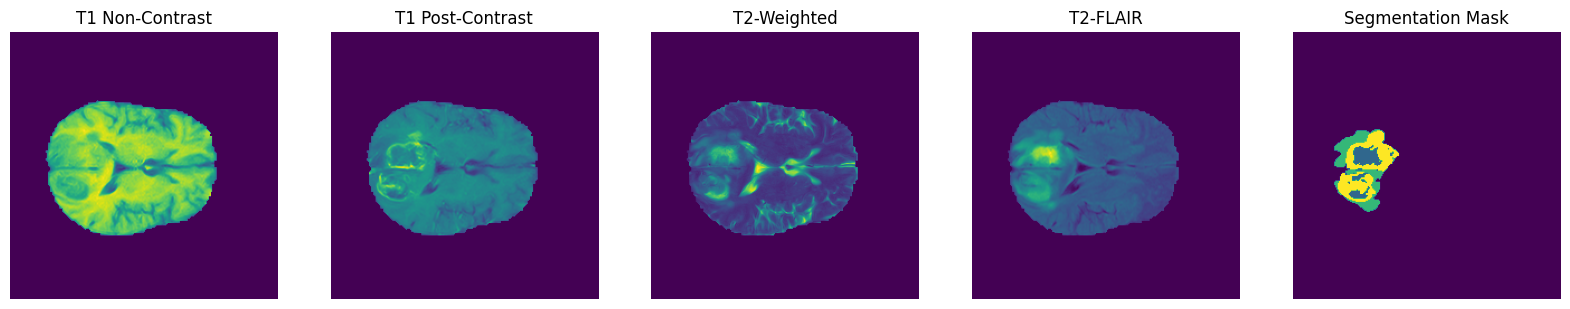

In [6]:
def visualize_sample(dataset, index=0):
    sample = dataset[index]
    t1n_slice = sample['t1n'].squeeze().numpy()
    t1c_slice = sample['t1c'].squeeze().numpy()
    t2w_slice = sample['t2w'].squeeze().numpy()
    t2f_slice = sample['t2f'].squeeze().numpy()
    seg_slice = sample['seg'].squeeze().numpy()

    fig, ax = plt.subplots(1, 5, figsize=(20, 5))
    ax[0].imshow(t1n_slice)
    ax[0].set_title('T1 Non-Contrast')
    ax[0].axis('off')
    ax[1].imshow(t1c_slice)
    ax[1].set_title('T1 Post-Contrast')
    ax[1].axis('off')
    ax[2].imshow(t2w_slice)
    ax[2].set_title('T2-Weighted')
    ax[2].axis('off')
    ax[3].imshow(t2f_slice)
    ax[3].set_title('T2-FLAIR')
    ax[3].axis('off')
    ax[4].imshow(seg_slice)
    ax[4].set_title('Segmentation Mask')
    ax[4].axis('off')
    plt.show()

# Visualize first scan
visualize_sample(train_dataset, index=0)

## Dice function

In [6]:
def dice_coefficient(pred, target, epsilon=1e-6):
    intersection = np.sum(pred * target)
    union = np.sum(pred) + np.sum(target)
    dice = (2 * intersection + epsilon) / (union + epsilon)
    return dice

## Simple CNN

In [7]:
class SimpleCNN(nn.Module):
  def __init__(self):
      super(SimpleCNN, self).__init__()
      self.conv1 = nn.Conv2d(4, 16, kernel_size=3, padding=1)
      self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
      self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
      self.conv4 = nn.Conv2d(64, 4, kernel_size=3, padding=1)
      self.relu = nn.ReLU()
      self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
      self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

  def forward(self, x):
      x = self.relu(self.conv1(x))
      x = self.maxpool(x)
      x = self.relu(self.conv2(x))
      x = self.maxpool(x)
      x = self.relu(self.conv3(x))
      x = self.maxpool(x)
      x = self.relu(self.conv4(x))
      x = self.upsample(x)
      x = self.upsample(x)
      x = self.upsample(x)
      return x

### Training

In [21]:
# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training
num_epochs = 5
model.train()

for epoch in range(num_epochs):
  epoch_loss = 0
  for batch in train_loader:
    t1n = batch['t1n'].to(device)
    t1c = batch['t1c'].to(device)
    t2w = batch['t2w'].to(device)
    t2f = batch['t2f'].to(device)
    seg = batch['seg'].to(device)

    # Concatenate inputs along the channel dimension
    inputs = torch.cat((t1n, t1c, t2w, t2f), dim=1)

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, seg)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader)}')

# Save trained model
model_path = '/content/drive/MyDrive/BraTs/models/simple_cnn.pth'
torch.save(model.state_dict(), model_path)

Epoch 1/5, Loss: 0.9843629801815207
Epoch 2/5, Loss: 0.11207860774558151
Epoch 3/5, Loss: 0.07416278080111652
Epoch 4/5, Loss: 0.06913900094558344
Epoch 5/5, Loss: 0.06586971301162108


### Evaluation

In [9]:
# Loading trained model from Google Drive
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = SimpleCNN().to(device)
#model_path = '/content/drive/MyDrive/BraTs/models/simple_cnn.pth'
#model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, jaccard_score

def evaluate_model(model, val_loader, device):
    model.eval()

    all_preds = []
    all_targets = []
    lesion_dice_scores = []

    with torch.no_grad():
        for batch in val_loader:
            t1n = batch['t1n'].to(device)
            t1c = batch['t1c'].to(device)
            t2w = batch['t2w'].to(device)
            t2f = batch['t2f'].to(device)
            seg = batch['seg'].to(device)

            inputs = torch.cat((t1n, t1c, t2w, t2f), dim=1)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            seg = seg.cpu().numpy()

            all_preds.extend(preds.flatten())
            all_targets.extend(seg.flatten())

            for i in range(preds.shape[0]):
                pred_batch = preds[i]
                seg_batch = seg[i]

                pred_labels, num_pred_lesions = label(pred_batch)
                seg_labels, num_seg_lesions = label(seg_batch)

                for lesion_num in range(1, num_seg_lesions + 1):  # Skipping background label 0
                    seg_lesion = seg_batch == lesion_num
                    pred_lesion_labels = pred_labels[seg_lesion]
                    pred_lesion_num = mode(pred_lesion_labels[pred_lesion_labels != 0])[0]

                    if pred_lesion_num.size > 0:
                        pred_lesion = pred_batch == pred_lesion_num
                        dice = dice_coefficient(pred_lesion, seg_lesion)
                        lesion_dice_scores.append(dice)

    mean_lesion_dice = np.mean(lesion_dice_scores) if lesion_dice_scores else 0
    print(f'Mean Lesion-wise Dice Coefficient: {mean_lesion_dice:.4f}')

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Compute confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    print('Confusion Matrix:\n', cm)

    # Compute Precision, Recall, and F1 Score
    precision = precision_score(all_targets, all_preds, average='weighted')
    recall = recall_score(all_targets, all_preds, average='weighted')
    f1 = f1_score(all_targets, all_preds, average='weighted')
    jaccard = jaccard_score(all_targets, all_preds, average='weighted')

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Jaccard Index: {jaccard:.4f}')

    return mean_lesion_dice, precision, recall, f1, jaccard, cm

# Evaluate the model
mean_lesion_dice, precision, recall, f1, jaccard, cm = evaluate_model(model, val_loader, device)

In [ ]:
# Visualize some predictions and ground truth
def visualize_predictions(model, data_loader, device, num_examples=3):
    model.eval()
    examples = 0
    with torch.no_grad():
        for batch in data_loader:
            t1n = batch['t1n'].to(device)
            t1c = batch['t1c'].to(device)
            t2w = batch['t2w'].to(device)
            t2f = batch['t2f'].to(device)
            seg = batch['seg'].to(device)

            inputs = torch.cat((t1n, t1c, t2w, t2f), dim=1)
            outputs = model(inputs)
            preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)

            # Loop through the batch and plot the results
            for i in range(inputs.size(0)):
                if examples >= num_examples:
                    return
                fig, axarr = plt.subplots(1, 3, figsize=(15, 5))
                axarr[0].imshow(inputs[i, 0].cpu().numpy())
                axarr[0].set_title('Input Image')
                axarr[1].imshow(seg[i].cpu().numpy())
                axarr[1].set_title('Ground Truth')
                axarr[2].imshow(preds[i].cpu().numpy())
                axarr[2].set_title('Predicted Mask')
                plt.show()
                examples += 1

# Visualize some examples from the validation data
visualize_predictions(model, val_loader, device)